In [5]:
import json
import logging
import sys

import nest_asyncio
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

from TiktokAPI import TiktokAPI

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
nest_asyncio.apply()

with open("../config.json") as f:
  tikapi = TiktokAPI(json.loads(f.read())["Tiktok"])

In [6]:
keywords = [
    "chemical spill ohio",
    "Derail",
    "Derailment",
    "ohio polyvinyl chloride",
    "ohio train wreck water",
    "ohio water test",
    "OhioTrainCrash",
    "Ohiotrainderailed",
    "Ohiouncuredpvc",
    "VinylChloride",
]

### 1. Query Tiktok video data by keyword

In [ ]:
for query in keywords:
    result = tikapi.query(query)
    with open(f"../data/tiktok/query_result/{query}.json", "w") as f:
        f.write(json.dumps(result))

### 2. Time series analysis

In [7]:
dfs = list()
for keyword in keywords:
    videos = list()
    with open(f"../data/tiktok/query_result/{keyword}.json", "r") as f:
        for content in json.loads(f.read()):
            try:
                videos.extend(content["item_list"])
            except Exception:
                continue
    df_keyword = tikapi.prase_video_result(videos)
    df_keyword["Keyword"] = keyword
    dfs.append(df_keyword)
df_videos = pd.concat(dfs)
df_videos = df_videos[(df_videos["Date"] >= "20230203") & (df_videos["Date"] <= "20230228")].dropna(subset=["CreateTime"])
df_videos = df_videos[df_videos["Title"].str.lower().str.contains("derail", regex=True)]
df_videos = df_videos[~df_videos.index.duplicated(keep="first")]

In [10]:
df_videos[df_videos["Date"]=="20230206"].sort_values(["AuthorFollower"])

,CreateTime,Title,Comment,Play,Share,Dig,Duration,AuthorId,AuthorFollower,AuthorHeart,AuthorVideoCount,EST,Date,Keyword
Id,,,,,,,,,,,,,,
7197191393574473003,1675726713,#fyp #fypシ゚viral #trainderailed #trainderailme...,847,141200,465,5517,45,6846451918425424902,521,9831,33,2023-02-06 18:38:33,20230206,Derailment
7197232439377546542,1675736270,Anyone elses stomach drop. 3am #trainderail #e...,597,752400,1223,35500,9,6645511584607780869,985,36800,16,2023-02-06 21:17:50,20230206,Derailment
7196982540870405422,1675678181,just happened overnight in Palestine Ohio. ple...,204,224600,1253,3671,85,6897326807193125893,1038,9008,320,2023-02-06 05:09:41,20230206,Derailment
7197262038920351022,1675743158,"Feb. 3rd a Train derailed in East Palestine, O...",146,85300,95,1626,32,6590521154318352389,1734,78300,45,2023-02-06 23:12:38,20230206,Derail
7197185835509222698,1675725418,Toxic train derailment in Ohio today February ...,217,209800,875,2352,145,6865698921956590597,5644,57100,232,2023-02-06 18:16:58,20230206,Derailment
7197130442489793838,1675712525,DANGER! #evacuation #eastpalestineohio #trai...,459,166700,880,2886,141,6993094527101060102,5941,74700,147,2023-02-06 14:42:05,20230206,Derailment
7197166765598641450,1675720978,Controlled explosion of derailed train. #eastp...,623,266400,615,9581,27,6606733169637588997,7455,1900000,7,2023-02-06 17:02:58,20230206,Derail
7196903178548366638,1675659622,#ohio #evacuation #explosion #fire #trainderai...,740,1200000,2764,14800,16,7014279127235183621,38900,783200,173,2023-02-06 00:00:22,20230206,Derailment
7197262870793473322,1675743353,I’ve been away from TikTok dealing with some f...,10100,7500000,73700,679500,175,6742947452208514054,283900,4900000,323,2023-02-06 23:15:53,20230206,chemical spill ohio


In [1]:
def build_features(df_videos: pd.DataFrame) -> pd.DataFrame:
    date_index = pd.DatetimeIndex(df_videos["Date"].drop_duplicates().sort_values())
    df_features = pd.DataFrame(index=date_index)

    video_count = df_videos.groupby(["Date"]).count()["Play"]
    video_play = df_videos.groupby(["Date"]).sum()["Play"]
    video_author = df_videos.groupby(["Date"]).mean()["AuthorFollower"]

    for col, df in [("Video Count", video_count),
                    ("Video Attention", video_play),
                    ("Author Attention", video_author)]:
        df.index = pd.DatetimeIndex(df.index)
        df_features[col] = df

    df_features = df_features.fillna(0)
    return df_features

df_features = build_features(df_videos)
df_features = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns, index=df_features.index)
df_features.plot(grid=True, figsize=(15, 5))

NameError: name 'pd' is not defined

In [ ]:
df_features.to_csv("../data/tiktok/DerailmentFeatures.csv", index_label="Date", sep="\t")

In [3]:
pd.read_csv("../data/tiktok/DerailmentFeatures.csv", index_col="Date", sep="\t")

,Video Count,Video Attention,Author Attention
Date,,,
2023-02-04,0.137931,0.090184,0.668402
2023-02-05,0.034483,0.000000,0.000000
2023-02-06,0.413793,0.494028,0.221453
2023-02-07,0.103448,0.013975,0.033964
2023-02-08,0.137931,0.060780,0.571802
2023-02-09,0.068966,0.362944,1.000000
2023-02-10,0.068966,0.225840,0.806709
2023-02-11,0.103448,0.199052,0.069663
2023-02-12,0.413793,0.279320,0.025627


### 3. Nuclear Leak Analysis

In [9]:
videos = list()
with open(f"../data/tiktok/query_result/NuclearLeak.json", "r") as f:
    for content in json.loads(f.read()):
        try:
            videos.extend(content["item_list"])
        except Exception:
            continue
df_videos = tikapi.prase_video_result(videos)
df_videos = df_videos[(df_videos["Date"] >= "20230308") & (df_videos["Date"] <= "20230331")].dropna(subset=["CreateTime"])
df_videos = df_videos[~df_videos.index.duplicated(keep="first")]

<AxesSubplot: >

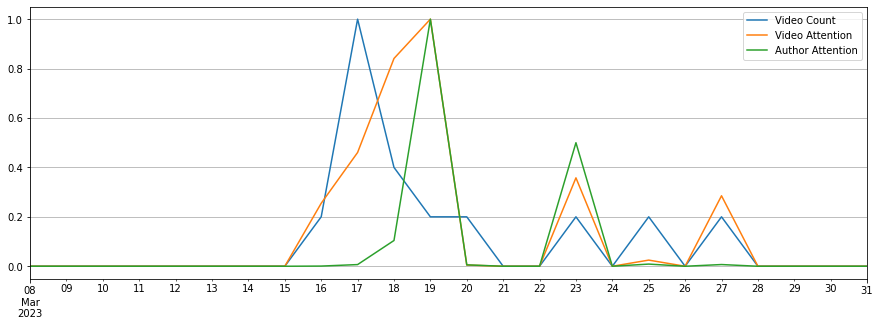

In [22]:
df_features = build_features(df_videos)
df_features = pd.DataFrame(index=pd.date_range("20230308", "20230331")).merge(df_features, left_index=True, right_index=True, how="left").fillna(0)
df_features = pd.DataFrame(MinMaxScaler().fit_transform(df_features), columns=df_features.columns, index=df_features.index)
df_features.plot(grid=True, figsize=(15, 5))

In [12]:
df_features.to_csv("../data/tiktok/NuclearFeatures.csv", index_label="Date", sep="\t")